In [2]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# 1. Carregar os dados
train_df = pd.read_csv("Train_data.csv")
test_df  = pd.read_csv("Test_data.csv")

print("Shape treino:", train_df.shape)
print("Colunas treino:", train_df.columns)
print("Valor único da coluna alvo:\n", train_df["class"].value_counts(dropna=False))
print("\n===================\n")

print("Shape Teste:", test_df.shape)
print("Colunas teste:", test_df.columns)

Shape treino: (25192, 42)
Colunas treino: Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')
Valor único da coluna alvo:
 class
normal     13449
anomaly    11743
Name: count, dtype: int64


Shape Test

In [6]:
# 2. Separar variáveis preditoras (X) e alvo (y)
X_train_raw = train_df.drop('class', axis=1)
y_train_raw = train_df['class']
X_test_raw = test_df  # O arquivo de teste não tem a coluna 'class'

In [7]:
# 3. Pré-processamento: Codificação de Variáveis Categóricas
# Combinamos treino e teste temporariamente para garantir as mesmas colunas (dummies)
combined_df = pd.concat([X_train_raw, X_test_raw], axis=0)
cat_cols = ['protocol_type', 'service', 'flag']
combined_encoded = pd.get_dummies(combined_df, columns=cat_cols)

# Separamos novamente
X_train_encoded = combined_encoded.iloc[:len(train_df)]
X_test_encoded = combined_encoded.iloc[len(train_df):]

In [8]:
# 4. Codificar o alvo (Target) para números
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_raw)

In [9]:
# 5. Escalonamento (Feature Scaling) - Crucial para KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [10]:
# 6. Divisão para Validação (Opcional, mas recomendado para checar performance)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train_encoded, test_size=0.2, random_state=42
)

In [11]:
print("\n--- Avaliando diferentes valores de n_neighbors ---")
# 7. Treinar e avaliar o modelo com diferentes n_neighbors
neighbors_to_test = [1, 3, 5, 7, 9, 11, 15] # Valores de n_neighbors para testar

for n in neighbors_to_test:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_split, y_train_split)
    y_pred_val = knn.predict(X_val_split)
    acc = accuracy_score(y_val_split, y_pred_val)
    print(f"n_neighbors = {n}: Acurácia na validação: {acc:.4%}")

# Exemplo de relatório de classificação para um n_neighbors específico (por exemplo, 1)
knn_best = KNeighborsClassifier(n_neighbors=1) # Ou o valor que apresentou melhor resultado
knn_best.fit(X_train_split, y_train_split)
y_pred_val_best = knn_best.predict(X_val_split)
print("\nRelatório de Classificação para n_neighbors=1 (exemplo):\n")
print(classification_report(y_val_split, y_pred_val_best, target_names=le.classes_))


--- Avaliando diferentes valores de n_neighbors ---
n_neighbors = 1: Acurácia na validação: 99.5039%
n_neighbors = 3: Acurácia na validação: 99.4443%
n_neighbors = 5: Acurácia na validação: 99.3650%
n_neighbors = 7: Acurácia na validação: 99.3253%
n_neighbors = 9: Acurácia na validação: 99.2459%
n_neighbors = 11: Acurácia na validação: 99.2657%
n_neighbors = 15: Acurácia na validação: 99.1070%

Relatório de Classificação para n_neighbors=1 (exemplo):

              precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99      2365
      normal       1.00      1.00      1.00      2674

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



In [12]:
# 8. Treinar com TODOS os dados e prever no Teste final
# Usamos um n_neighbors otimizado ou um valor que funcionou bem
knn_full = KNeighborsClassifier(n_neighbors=1) # Ajuste este valor se a análise acima sugerir outro
knn_full.fit(X_train_scaled, y_train_encoded)

KNeighborsClassifier(n_neighbors=1)

In [13]:
# Previsão final
test_predictions_encoded = knn_full.predict(X_test_scaled)
test_predictions_labels = le.inverse_transform(test_predictions_encoded)

# Salvar resultado
output = pd.DataFrame({'id': range(len(test_predictions_labels)), 'class': test_predictions_labels})
output.to_csv('knn_predictions.csv', index=False)
print("\nPrevisões salvas em 'knn_predictions.csv'")


Previsões salvas em 'knn_predictions.csv'


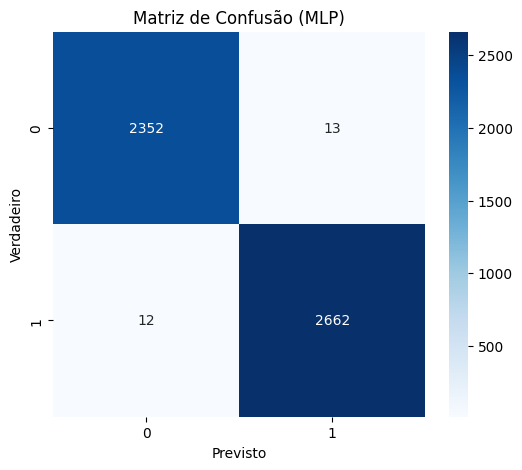

In [14]:
cm = confusion_matrix(y_val_split, y_pred_val_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão (MLP)")
plt.show()


--- Calculando Importância por Permutação ---
Top 20 Características originais mais importantes:


,Feature,Importance_Mean
39,service,0.122842
40,flag,0.020083
31,dst_host_diff_srv_rate,0.010300
32,dst_host_same_src_port_rate,0.009684
6,hot,0.007680
29,dst_host_srv_count,0.007005
33,dst_host_srv_diff_host_rate,0.006747
27,srv_diff_host_rate,0.006073
24,srv_rerror_rate,0.005815
28,dst_host_count,0.005557


/tmp/ipython-input-607062398.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance_Mean', y='Feature', data=final_importance_df.head(20), palette='viridis')


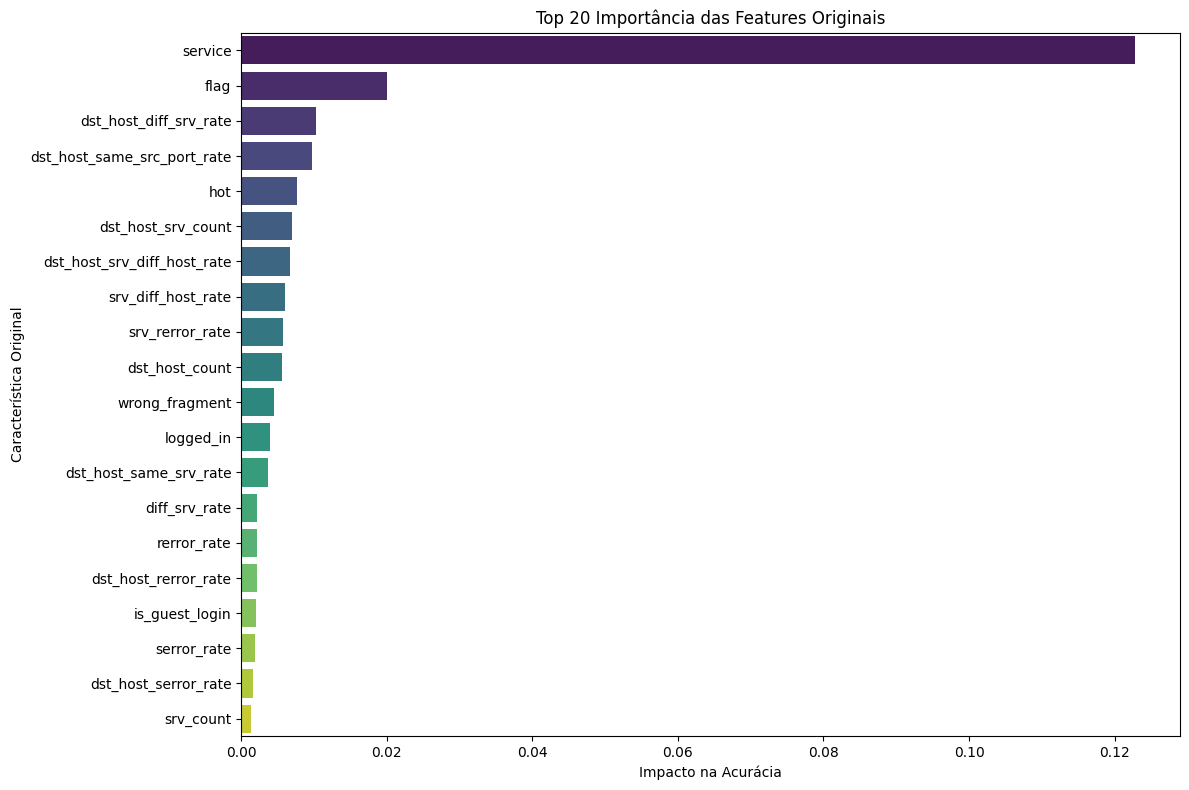

In [19]:
print("\n--- Calculando Importância por Permutação ---")

# Calculate permutation importance on the validation set
result = permutation_importance(knn_best, X_val_split, y_val_split, n_repeats=10, random_state=42, n_jobs=-1)

# Get feature names from the encoded training data
feature_names = X_train_encoded.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': result.importances_mean,
    'Importance_Std': result.importances_std
})

# --- Agregação para colunas originais ---
aggregated_importance_data = {}
cat_cols = ['protocol_type', 'service', 'flag'] # Colunas categóricas originais

for index, row in importance_df.iterrows():
    feature = row['Feature']
    importance_mean = row['Importance_Mean']

    # Verifica se a feature é uma variável dummy de uma coluna categórica
    is_categorical_dummy = False
    for original_cat_col in cat_cols:
        if feature.startswith(f'{original_cat_col}_'):
            # Agrega a importância sob o nome da coluna categórica original
            if original_cat_col not in aggregated_importance_data:
                aggregated_importance_data[original_cat_col] = 0
            aggregated_importance_data[original_cat_col] += importance_mean
            is_categorical_dummy = True
            break

    if not is_categorical_dummy:
        # Se não é uma variável dummy, é uma coluna numérica original
        if feature not in aggregated_importance_data:
            aggregated_importance_data[feature] = 0
        aggregated_importance_data[feature] += importance_mean # Para features numéricas, a importância é direta

# Converte o dicionário agregado em um DataFrame
final_importance_df = pd.DataFrame(
    list(aggregated_importance_data.items()),
    columns=['Feature', 'Importance_Mean']
)

# Ordena pela importância
final_importance_df = final_importance_df.sort_values(by='Importance_Mean', ascending=False)

print("Top 20 Características originais mais importantes:")
display(final_importance_df.head(20))

# Visualize top N features
plt.figure(figsize=(12, 8)) # Aumentei o tamanho da figura para acomodar mais features
sns.barplot(x='Importance_Mean', y='Feature', data=final_importance_df.head(20), palette='viridis')
plt.title("Top 20 Importância das Features Originais")
plt.xlabel("Impacto na Acurácia")
plt.ylabel("Característica Original")
plt.tight_layout()
plt.show()


Correlação entre src_bytes e dst_bytes:

           src_bytes  dst_bytes
src_bytes   1.000000   0.003611
dst_bytes   0.003611   1.000000


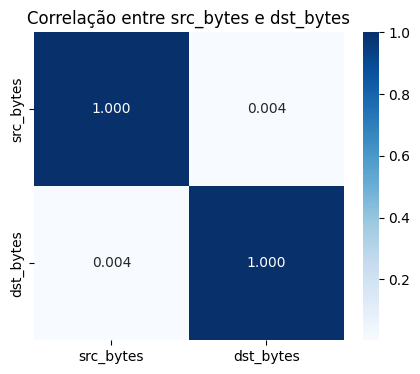

In [22]:
corr = train_df[['src_bytes', 'dst_bytes']].corr()

print("\nCorrelação entre src_bytes e dst_bytes:\n")
print(corr)

# Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".3f")
plt.title("Correlação entre src_bytes e dst_bytes")
plt.show()

In [23]:
# 1. Identificar os 10 serviços mais frequentes
top_services = train_df['service'].value_counts().head(10).index

# 2. Filtrar o DataFrame para incluir apenas os top 10 serviços
df_top_services = train_df[train_df['service'].isin(top_services)]

print(f"Top 10 serviços mais frequentes: {list(top_services)}")


Top 10 serviços mais frequentes: ['http', 'private', 'domain_u', 'smtp', 'ftp_data', 'eco_i', 'other', 'ecr_i', 'telnet', 'finger']


/tmp/ipython-input-2042480153.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='service', y='src_bytes', data=df_top_services, palette='viridis')
/tmp/ipython-input-2042480153.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='service', y='dst_bytes', data=df_top_services, palette='magma')


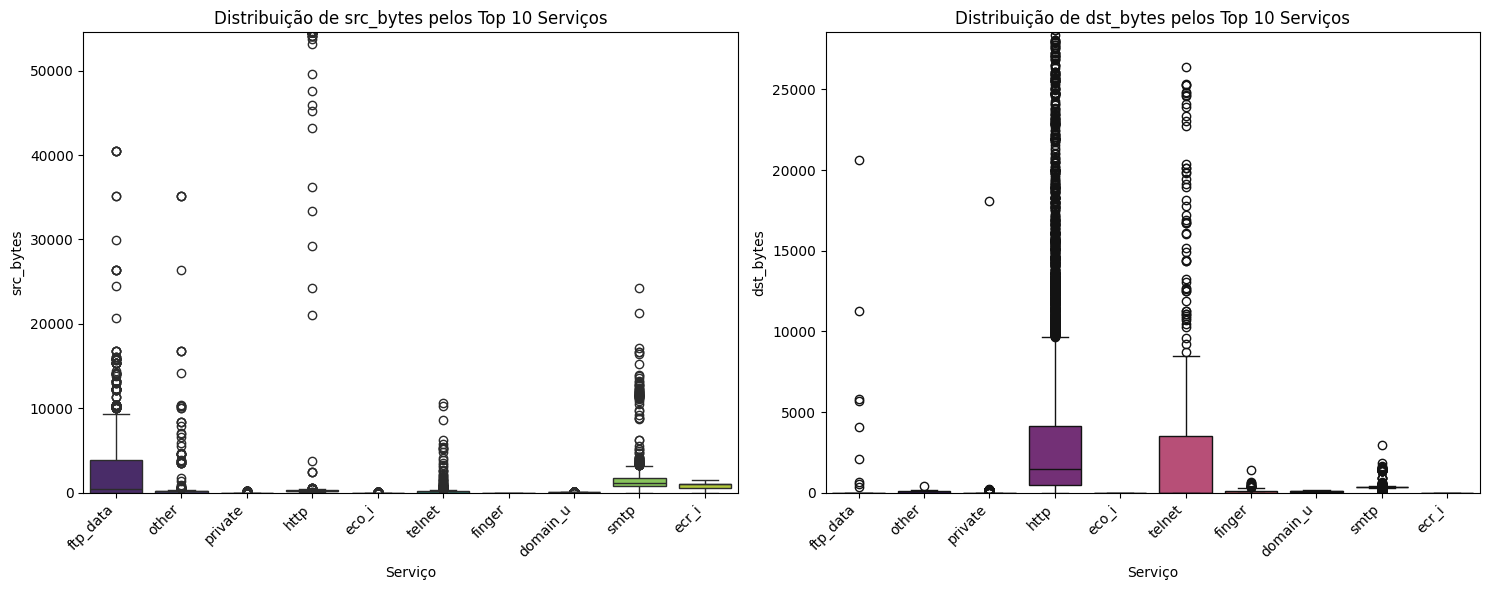

In [24]:
plt.figure(figsize=(15, 6))

# Box plot para src_bytes por serviço
plt.subplot(1, 2, 1) # 1 linha, 2 colunas, primeiro gráfico
sns.boxplot(x='service', y='src_bytes', data=df_top_services, palette='viridis')
plt.title('Distribuição de src_bytes pelos Top 10 Serviços')
plt.xlabel('Serviço')
plt.ylabel('src_bytes')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, df_top_services['src_bytes'].quantile(0.99)) # Limita o eixo Y para melhor visualização (ignorando outliers extremos)

# Box plot para dst_bytes por serviço
plt.subplot(1, 2, 2) # 1 linha, 2 colunas, segundo gráfico
sns.boxplot(x='service', y='dst_bytes', data=df_top_services, palette='magma')
plt.title('Distribuição de dst_bytes pelos Top 10 Serviços')
plt.xlabel('Serviço')
plt.ylabel('dst_bytes')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, df_top_services['dst_bytes'].quantile(0.99)) # Limita o eixo Y para melhor visualização (ignorando outliers extremos)

plt.tight_layout()
plt.show()